## Basic PRM Algorithm

Algorithms:

1. construct a roadmap in a probabilistic way (for a given configuration space)
  - roadmap is represented by an undirected graph $G= (V,E)$ that captures connectivity of a space.
  - nodes in $V$ are robot configurations sampled randomly from a uniform  distribution over $Q_{free}$, the free configuration space.
  - edges in $E$ represent connectedness in $Q_{free}$ (hence are undirected) and correspond to collision-free paths; an edge $(q_1, q_2)$ is such a path connecting configurations $q_1$ and $q_2$.
  - each edge is a local path generated by a local planner, $\Delta$; a simple local planner connects two nodes by a straight path in $Q_{free}$, if such a path exists.

2. query roadmap to solve for a path between a start and a goal configuration ($q_{start}$ and $q_{goal}$, respectively)
  - connect $q_{start}$ and $q_{goal}$ to two nodes $q'$ and $q''$, respectively, in $V$, if possible
  - search the graph for a sequence of edges in $E$ connecting $q'$ to $q''$
  - then recompute local paths and concatenate them from $q_{start}$ to $q_{goal}$

#### Related Concepts:

ConfigurationSpace comprises Configuration and ObstacleRegion both within Bounds.

Configuration represents a location in ConfigurationSpace.

ObstacleRegion represents a contiguous area of ConfigurationSpace such that a Configuration within the area is in collision with an Obstacle or violates a holonomic (pose) constraint.

LocalPlanner connects a collision-free Configuration pair with a Path (collision-free) if such exists.

Roadmap represents ConfigurationSpace as an UndirectedWeightedGraph with Configuration as graph nodes and graph edges representing Configuration pairs connected by a local Path.

UndirectedWeightedGraph is a graph structure with weighted edges between nodes. The weight associated with each edge is the cost of going from one node to another along that edge.

ProbabilisticRoadmap does the following:
 - builds a Roadmap given a ConfigurationSpace
 - plans global Path from a given start Configuration to a give goal Configuration.

TnT:
 - PRM
 - Vector util representation of CSpace locations


In [ ]:
# from abc import ABC, abstractmethod

# class Configuration(ABC):
#   @abstractmethod
#   def as_tuple(self) -> tuple:
#     ...

# class ConfigurationSpace(ABC):
#   @abstractmethod
#   def is_collision_free(self, configuration) -> bool:
#     ...

### Basic PRM Pseudocode

In [ ]:
# Algorithm 1: roadmap construction algorithm (pseudocode)

# Inputs:
# n: number of nodes to put in the roadmap
# k: number of closest neighbours to examine for each configuration
#
# Output:
# roadmap G = (V,E)

# V = {}
# E = {}
#
# while len(V) < n:
#
#   while True:
#     q = sample_configuration(Q, uniform)
#
#     if is_collision_free(q):
#       V.append(q)
#       break
#
# for q in V:
#   q_neighbourhood = get_k_neighbours(q, k, distance_metric, Q)
#
#     for q_neighbour in q_neighbourhood:
#       if (q, q_neighbour) not in E and \
#           local_path_exists(q, q_neighbour, local_planner):
#         E.append((q, q_neighbour))


In [ ]:
# Algorithm 2: query roadmap algorithm (pseudocode)

# Inputs:
# qinit: the initial configuration
# qgoal: the goal configuration
# k: the number of closest neighbours to examine for each configuration
# G = (V,E): the roadmap computed by algorithm 1
#
# Output:
# A path from qinit to qgoal or "failure"

# qinit_neighbourhood = get_neighbours(qinit, k, distance_metric, V)
# qgoal_neighbourhood = get_neighbours(qgoal, k, distance_metric, V)
# V.extend({qinit, qgoal})
# qprime = get_closest_neighbours(qinit, qinit_neighbourhood)  # NOTE: return ranked list of neighbours (same as get_neighbours)
#
# for close_neighbour in qprime:
#   if local_path_exists(qinit, close_neighbour, local_planner):
#     E.append((qinit, close_neighbour))
#     break
#
# q_prime = get_closest_neighbours(qgoal, qgoal_neighbourhood)
# for close_neighbour in q_prime:
#   if local_path_exists(qgoal, close_neighbour, local_planner):
#     E.append((qinit, close_neighbour))
#     break
#
# P = find_shortest_path(start=qinit, end=qgoal, on=G)
# if P is not NULL:
#   return P
# else:
#   return 'failure'

### Algorithm Implementations

In [2]:
# Implementation of Algorithm 1

# Assumptions:
# Q is the closed bounded 2D Euclidean rectangle from [0,0] to [x,y]
# each obstacle is a closed disk in Q defined by centre coordinates and a radius
# local_planner finds a straight line path between points or returns None

from abc import ABC, abstractmethod
from decimal import Decimal
from typing import Generic, Callable, Literal, Protocol, TypeVar


# define generics: Location, NDConfiguration
NDConfiguration = Location = TypeVar("Location", bound=tuple[float,...])
DistanceMetric = Callable[[Location, Location], float]
Bounds2D = TypeVar("Bounds2D")
Obstacle2D = TypeVar("Obstacle2D")
ConfigurationSpace = TypeVar("ConfigurationSpace")


# define protocol for Roadmap: a static-typing interface for implementing classes
class UndirectedWeightedGraph(ABC):
  """
  This abstract class represents an undirected weighted graph.
    Useful for trees, roadmaps, etc.
  """
  _edges: dict[Location: list[Location]]
  _weight: DistanceMetric

  @property
  @abstractmethod
  def edges(self):
    """
    Class property getter representing edges in the graph
    """
    return self._edges

  @property
  @abstractmethod
  def nodes(self):
    """
    Abstract property representing edges in the graph
    """
    return list(self._edges)

  @abstractmethod
  def neighbours(self, node: Location) -> list[Location]:
    """
    Gets the neighbours of the given node.
      A neighbour has an edge from the given node to itself.

      Args:
        node (Node): The node for which neighbours are required.

      Returns:
        list[Node]: A list of all neighbouring Nodes.
    """
    ...

  @abstractmethod
  def cost(self, start: Location, goal: Location) -> float:
    """
    Calculates the weight of the edge between fro and to nodes.

      Returns:
        float: The weight of the edge
    """
    ...

  def add_node(self, node: Location) -> None:
    self._edges[node] = self._edges.get(node, [])

  def add_edge(self, node1: Location, node2: Location):
    # prevent multiple calls, so add to both
    if node2 not in self._edges[node1]:
      self._edges[node1].append(node2)

    if node1 not in self.edges[node2]:
      self._edges[node2].append(node1)

  def get_nodes(self):
    return [n for n in self._edges]

  def neighbours(self, node: Location) -> list[Location]:
    return self._edges.get(node, None)

  def edge_between(self, node1: Location, node2: Location):
    return (
      node2 in self._edges.get(node1, []) and node1 in self._edges.get(node2, [])
    )

  def node_exists(self, node: Location) -> bool:
    return (node in self._edges)

  #TODO: update to VectorND
  def default_cost(self, node1: Location, node2: Location) -> float:
    """
    Calculates the weight of the edge between node1 and node2.

      Returns:
        float: The weight of the edge
    """
    return Vector2D.norm(
        Vector2D(*tuple(goal)) - Vector2D(*tuple(start))
      )

  def unique_edges(self) -> list[tuple[Location, Location]]:
    edge_set = []
    # for all nodes
    for node in self._edges:
      # with connected neighbours
      for connected_node in self._edges.get(node, []):
        # get each edge as tuple[node, connected_node]
        edge_pair = (node, connected_node)
        # add to edge_set if not there
        if (connected_node, node) not in edge_set:
          edge_set.append(edge_pair)

    return edge_set


# define vector class
class Vector2D:
  """
    This class represents a 2D vector.
    Args:
      x (float): The x-coordinate of the vector.
      y (float): The y-coordinate of the vector.

    Attributes:
      x (float): The x-coordinate of the vector.
      y (float): The y-coordinate of the vector.

    Methods:
      norm(self, vector): Calculate the magnitude of the vector.
      __sub__(self, other): Overload the minus operator to perform vector subtraction.
      __add__(self, other): Overload the plus operator to perform vector addition.
      distance(self, other): Calculate the distance between two vectors.
      displacement(self, other): Aliases vector subtraction.
      unit_vector(self): Calculate the unit vector of the vector.

    Sample code:
      ```python
        ### Create two vector instances
        v1 = Vector(3, 4)
        v2 = Vector(1, 2)

        ### Calculate the norm of v1
        print(Vector.norm(v1))  # Output: 5.0

        ### Calculate the displacement between v1 and v2
        displacement = v1 - v2
        print(displacement.x, displacement.y)  # Output: (2, 2)

        ### Calculate the distance between v1 and v2
        print(v1.distance(v2))  # Output: 2.8284271247461903

        ### Calculate the unit vector of v1
        unit_v1 = v1.unit_vector()
        print(unit_v1.x, unit_v1.y)  # Output: (0.6, 0.8)
      ```
  """

  def __init__(self, x: float, y: float):
    self.x = float(x)
    self.y = float(y)

  @classmethod
  def from_configuration2D(cls, config):
    """ create Vector2D object from a Configuration2D object """

    return cls(config.x, config.y)

  @classmethod
  def get_displacement_vector(cls, start_vector, end_vector):
    """ Calculate displacement vector that points from start to end """

    return end_vector - start_vector

  # define static norm method
  @staticmethod
  def norm(vector) -> float:
    """ Calculate the magnitude(length) of the vector """

    return (vector.x ** 2 + vector.y ** 2) ** 0.5

  def __sub__(self, other):
    """ Overload the minus operator to perform vector subtraction """

    return Vector2D(self.x - other.x, self.y - other.y)

  def __add__(self, other):
    """ Overload the plus operator to perform vector addition """

    return Vector2D(self.x + other.x, self.y + other.y)

  def __truediv__(self, scalar):
    """ Overload division operator to perform scalar division """

    # TODO: catch divide by zero error
    return self * float(1 / scalar)

  def __mul__(self, scalar):
    """ Overload the multiply operator to perform scalar multiplication """

    return Vector2D(self.x * float(scalar), self.y * float(scalar))

  def __eq__(self, other):
    return (self.x, self.y) == (other.x, other.y)

  def __hash__(self):
    return hash((self.x, self.y))

  def __repr__(self):
    return f'Vector2D({self.x},{self.y})'

  def distance(self, other):
    """ Calculate the scalar distance between two vectors """

    return Vector2D.norm(other - self)

  def unit_vector(self):
    """ Calculate the unit vector """

    mag = Vector2D.norm(self)
    return self / mag

  def is_within_rho(self, other, rho: float):
    # check that distance between self and other is less than or equal to rho
    return self.distance(other) <= Decimal(value=rho)

  def as_tuple(self):
    return (self.x, self.y)

  def to_configuration2D(self):
    return Configuration2D(self.x, self.y)

# define configuration class with immutable x,y coordinates
# TODO: possible optimisation is to define this as a static type
# Configuration2D = tuple[float, float]
class Configuration2D(Generic[NDConfiguration]):
  """ Class representing a 2D configuration. """

  def __init__(self, x: float, y: float):
    """ Initialize the 2D configuration with x and y coordinates """

    self.x = x
    self.y = y

  # TODO: Implement immutable coordinates and update docstring
  # @property.method()
  # @prop.setter

  @classmethod
  def from_vector2D(cls, vector):
    """ create Configuration2D object from a Vector2D object """

    return cls(vector.x, vector.y)

  def to_vector2D(self):
    return Vector2D(self.x, self.y)

  def as_tuple(self):
    return (self.x, self.y)

  def __getitem__(self, index):
    return self.as_tuple()[index]

  def __eq__(self, other):
    return (self.x, self.y) == (other.x, other.y)

  def __hash__(self):
    return hash((self.x, self.y))

  def __repr__(self):
    return f'Configuration2D({self.x},{self.y})'

# define obstacle class
class DiskObstacle2D(Generic[Obstacle2D]):
  """
    This class represents a disk-shaped obstacle.

    Args:
      centre (tuple): The (x, y) coordinates of the center of the disk.
      radius (float): The radius of the disk.

    Attributes:
      centre (tuple): The (x, y) coordinates of the center of the disk.
      radius (float): The radius of the disk.
  """

  def __init__(self, centre: Location, radius: float):
    self.centre: Location = centre
    self.radius = radius

  def colliding_with(self, configuration):
    # check if the configuration is within the obstacle
    return self.contains(configuration)

  def contains(self, configuration):
    from math import hypot
    # calculate the distance between the configuration and the obstacle centre
    distance = hypot(configuration.x - self.centre[0],
                     configuration.y - self.centre[1])

    return distance <= self.radius

  def as_tuple(self):
    return (self.centre, self.radius)

  def __getitem__(self, index):
    return self.as_tuple()[index]

  def __repr__(self):
    return f'DiskObstacle2D(centre={self.centre}, radius={self.radius})'

# define bounds class
class RectangularBounds2D(Generic[Bounds2D]):

  def __init__(self,
             x_bounds: tuple[float, float],
             y_bounds: tuple[float, float]):
    # set boundary extremes
    self.x_min = float(min(x_bounds))
    self.x_max = float(max(x_bounds))
    self.y_min = float(min(y_bounds))
    self.y_max = float(max(y_bounds))

    self.x_bounds = (self.x_min, self.x_max)
    self.y_bounds = (self.y_min, self.y_max)

  def is_within_bounds(self, configuration):
    # check if the configuration is within bounds
    in_x_bounds = configuration.x >= self.x_min and configuration.x <= self.x_max
    in_y_bounds = configuration.y >= self.y_min and configuration.y <= self.y_max

    if in_x_bounds and in_y_bounds:
      return True

    return False

# define configuration space class
class ConfigurationSpace2D(Generic[ConfigurationSpace]):
  def __init__(self, bounds: Bounds2D, obstacle_list: list[Obstacle2D]):
    # initialise configuration space with bounds, obstacle list, metric
    self.bounds = bounds  # TODO: create from tuple and preferred bounds class
    self.obstacle_list = obstacle_list

  def is_collision_free(self, configuration):
    # check if configuration is in bounds
    if not self.bounds.is_within_bounds(configuration):
      return False

    # check if the given configuration is in collision with any obstacles
    for obstacle in self.obstacle_list:
      if obstacle.colliding_with(configuration):
        return False

    return True

  def distance_metric(self, start_configuration, goal_configuration) -> float:
    """
    Implement distance metric protocol.

      Returns:
        float:
          The scalar distance between start_configuration and goal_configuration
    """

    return Vector2D.norm(goal_configuration.to_vector2D() -
                  start_configuration.to_vector2D())

# define local planner class: construct obstacle-free edge between q' & q''
class SimpleLocalPlanner2D:
  def __init__(self, Q_space: ConfigurationSpace2D, resolution=0.01):
    self.configuration_space = Q_space
    self.resolution = float(resolution)

  def get_increment_vector(
      self,
      q_start: Configuration2D,
      q_goal: Configuration2D):
    v_start, v_goal = q_start.to_vector2D(), q_goal.to_vector2D()
    displacement_vector = Vector2D.get_displacement_vector(v_start, v_goal)
    direction_vector = displacement_vector.unit_vector()
    increment_vector = direction_vector * self.resolution

    return increment_vector

  def plan(self,
           start: Configuration2D,
           goal: Configuration2D) -> list[Configuration2D] | None:
    # generate resolution-apart configurations on straight line from start to goal
    # get increment vector (direction vector from start to goal scaled to resolution)
    # increment start to end
    # if collision: return None

    self.path = []

    v_increment = self.get_increment_vector(start, goal)
    current_config = start.to_vector2D()

    while self.configuration_space.is_collision_free(current_config):
      self.path.append(current_config)
      current_config += v_increment

      if current_config.is_within_rho(goal.to_vector2D(), rho=self.resolution):
        break

    if not current_config.is_within_rho(goal.to_vector2D(), rho=self.resolution):
      # no collision-free path exists
      return None

    # collision-free path exists
    assert self.configuration_space.is_collision_free(
        current_config), "current_config must be collision-free"

    assert current_config.is_within_rho(
        goal.to_vector2D(), self.resolution), "current_config must have reached goal"

    self.path = [x.to_configuration2D() for x in self.path]
    self.path.append(goal)

    assert start in self.path, "start must be in local path"
    assert goal in self.path, "goal must be in local path"
    return self.path

class Roadmap:
  """
  This class implements a roadmap as an UndirectedWeightedGraph.
  """

  def __init__(self, cost: DistanceMetric=None):
    self.edges: dict[Location, list[Location]] = {}  # each location points to all connected locations (neighbours)
    self.cost: DistanceMetric = cost

  def add_node(self, node: Location):
    self.edges[node] = self.edges.get(node, [])

  def init_nodes(self, node_list: list[Location]):
    self.edges = {node: list() for node in node_list}

  def add_edge(self, node1: Location, node2: Location):
    # prevent multiple calls, so add to both
    if node2 not in self.edges[node1]:
      self.edges[node1].append(node2)

    if node1 not in self.edges[node2]:
      self.edges[node2].append(node1)

  def get_nodes(self):
    return list(self.edges)

  def neighbours(self, node: Location) -> list[Location]:
    return self.edges.get(node, None)

  def edge_between(self, node1: Location, node2: Location):
    return (node2 in self.edges.get(node1, []) and node1 in self.edges.get(node2, []))

  def node_exists(self, node: Location) -> bool:
    return (node in self.edges)

  def default_cost(self, node1: Location, node2: Location) -> float:
    """
    Calculates the weight of the edge between node1 and node2.

      Returns:
        float: The weight of the edge
    """
    return Vector2D.norm(
        Vector2D(*tuple(goal)) - Vector2D(*tuple(start))
      )

  def unique_edges(self) -> list[tuple[Location, Location]]:
    edge_set = []
    # for all nodes
    for node in self.edges:
      # with connected neighbours
      for connected_node in self.edges.get(node, []):
        # get each edge as tuple[node, connected_node]
        edge_pair = (node, connected_node)
        # add to edge_set if not there
        if (connected_node, node) not in edge_set:
          edge_set.append(edge_pair)

    return edge_set

# define ...
class ProbabilisticRoadmap:
  def __init__(self,
               num_samples: int,
               num_nearest_neighbours: int,
               Q: ConfigurationSpace2D,
               local_planner: SimpleLocalPlanner2D = None):
    self.configuration_space = Q
    self.num_samples = num_samples
    self.num_nearest_neighbours = num_nearest_neighbours
    self.local_planner = local_planner

    # initialise roadmap graph, G = (V,E)
    self.nodes: list[Location] = []
    # self.edges: list[tuple[Location, Location]] = []
    self.roadmap: Roadmap = Roadmap(self.configuration_space.distance_metric)
    self._build_roadmap()

  def _build_roadmap(self):
    """
      Constructs the roadmap by sampling collision-free configurations
      and connecting them using a local planner.

      Returns:
        None
    """

    # sample num_sample configs
    while len(self.nodes) < self.num_samples:
      in_collision = True
      while in_collision:
        q = self.sample_configuration()
        in_collision = not self.configuration_space.is_collision_free(q)
      # add node for q to roadmap
      self.nodes.append(q)

    # add nodes to roadmap
    self.roadmap.init_nodes(self.nodes)

    # connect nodes
    for node in self.roadmap.edges:
      # PROBLEMS: node connects to itself; node connects across obstacles
      # get nearest neighbours
      neighbourhood = self.get_nearest_neighbours(node)
      assert len(neighbourhood) == self.num_nearest_neighbours, f"""
      k should be {self.num_nearest_neighbours} not {len(neighbourhood)}
      """.strip()

      # find local path to each neighbour
      for neighbour in neighbourhood:
        if neighbour not in self.roadmap.edges.get(node):  # node not in edge
          if self.local_path_exists(node, neighbour):
            # add edge to roadmap
            self.roadmap.add_edge(node, neighbour)

  def sample_configuration(self):
    """
      Samples a collision-free configuration within the configuration space.

      Returns:
        Configuration2D: The sampled configuration.
    """

    return sample_uniform_configuration2D(self.configuration_space.bounds)

  def is_collision_free(self, configuration):
    """
      Checks if the given configuration is collision-free within the configuration space.

      Args:
        configuration (Configuration2D): The configuration to check for collisions.

      Returns:
        bool: True if the configuration is collision-free, False otherwise.
    """

    return self.configuration_space.is_collision_free(configuration)

  def get_nearest_neighbours(self, node: Location) -> list[Location]:
    """
      Finds the k nearest neighbors of the given node within the roadmap.

      Args:
        node (Location): The node for which to find nearest neighbors.

      Returns:
        list[Location]: A list of k nearest neighbor nodes.
    """
    return(
        get_nearest_neighbours2D(
            node,
            self.num_nearest_neighbours,
            self.roadmap.edges.keys())
    )

  def local_path_exists(self, q_start: Configuration2D, q_goal: Configuration2D):
    """
    Checks if a collision-free local path exists between two configurations.

      Args:
        start_configuration (Configuration2D): The start configuration.
        end_configuration (Configuration2D): The end configuration.

      Returns:
        bool: True if local path exists, False otherwise.
    """

    if self.get_local_path(q_start, q_goal):
      return True

    return False

  def get_local_path(self, q_start: Configuration2D, q_goal: Configuration2D):
    """
    Checks for a collision-free path between two configurations.

      Args:
        start_configuration (Configuration2D): The start configuration.
        end_configuration (Configuration2D): The end configuration.

      Returns:
        List[Configuration2D] | None:
          A collision-free local path if it exists, None otherwise.
    """

    if self.local_planner is None:
      self.local_planner = SimpleLocalPlanner2D(self.configuration_space)

    return self.local_planner.plan(q_start, q_goal)

  def query_roadmap(self,
                    start_node: Location,
                    goal_node: Location,
                    num_nearest_neighbours: int = None) -> list[Location]:
    # get path from q_start to q_goal or return "Failure"

    k = num_nearest_neighbours or self.num_nearest_neighbours
    self.roadmap.add_node(start_node)
    self.roadmap.add_node(goal_node)
    start_neighbourhood = self.get_nearest_neighbours(start_node)
    goal_neighbourhood = self.get_nearest_neighbours(goal_node)

    connected = False
    # connect start and goal within the roadmap
    for neighbour in start_neighbourhood:
      if self.local_path_exists(start_node, neighbour):
        self.roadmap.add_edge(start_node, neighbour)
        connected = True
        break

    # terminate if start not connected
    if not connected:
      return "Failure"

    connected = False
    # connect goal within roadmap
    for neighbour in goal_neighbourhood:
      if self.local_path_exists(goal_node, neighbour):
        self.roadmap.add_edge(goal_node, neighbour)
        connected = True
        break

    # terminate if goal not connected
    if not connected:
      return "Failure"

    # assert current state
    assert (start_node in self.roadmap.edges), "start must have edge in roadmap"
    assert (goal_node in self.roadmap.edges), "goal must have edge in roadmap"

    # find path
    came_from, _ = a_star_search2D(
      graph=self.roadmap,
      start=start_node,
      goal=goal_node,
      heuristic=self.configuration_space.distance_metric
    )

    path: list[Location] = self.reconstruct_path(came_from, start_node, goal_node)

    return path or "Failure"

  def reconstruct_path(
      self,
      came_from: dict[Location, Location | None],
      start: Location,
      goal: Location,
      reverse: bool = True
    ) -> list[Location] | None:
    # pre-condition: [start, goal], came_from:{location: location}
    # post-condition: [start, ..., goal]
    # invariant: [..., came_from[current], current]
    # guard: current not None i.e. reached start

    reconstruction: list[Location] = []

    # early exit condition
    assert isinstance(goal, Configuration2D)
    assert isinstance(came_from, dict), f"{came_from}"
    if goal not in came_from:
      print("Can't find goal in `came_from`")
      return None

    # assert came_from assumption
    assert (came_from[start] is None), "start node must have None as parent"

    current: Location = goal
    while current is not None:
      reconstruction.append(current)
      current = came_from[current]

    if reverse:
      reconstruction.reverse()

    return reconstruction


# helper
import random
import decimal


def sample_uniform_configuration2D(
    bounds: RectangularBounds2D, resolution=0.01) -> Configuration2D:
  """
    Sample a 2D configuration from a uniform distribution over the given bounds.

    Args:
      bounds (RectangularBounds2D):
        The bounds within which to sample the 2D configuration.

    Returns:
      Configuration2D:
        The sampled 2D configuration in the form (x, y).

    Sample code:
      bounds = RectangularBounds2D((0, 10), (0, 10))
      sampled_config = sample_uniform_configuration2D(bounds)
      print(sampled_config)
  """

  # Sample x coordinate
  x_value = random.uniform(bounds.x_min, bounds.x_max)
  # Round the x value to two decimal places
  x_value = decimal.Decimal(x_value).quantize(decimal.Decimal("0.01"))
  # Sample y coordinate
  y_value = random.uniform(bounds.y_min, bounds.y_max)
  # Round the y value to two decimal places
  y_value = decimal.Decimal(y_value).quantize(decimal.Decimal("0.01"))
  # Return (x, y) coordinates as floats
  return Configuration2D(float(x_value), float(y_value))

def get_nearest_neighbours2D(
    node: Configuration2D,
    num_nearest_neighbours: int,
    node_list: list[Configuration2D]
  ) -> list[Configuration2D]:
  """
    Finds the k-nearest neighbors of the given node within the roadmap.

    Args:
      node (Configuration2D): The node for which to find nearest neighbors.
      num_nearest_neighbours (int): The number, k, of nearest nodes to return.
      node_list (list[Configuration2D]): List of nodes to search.

    Returns:
      list[Configuration2D]: A list of k nearest neighbor nodes.
  """

  # create node_dict to hold neighbour location and distance from node
  node_dict: dict[Location, float] = dict()
  origin_vec: Vector2D = node.to_vector2D()

  def default_metric(neighbour: Configuration2D) -> float:
    return origin_vec.distance(
        neighbour.to_vector2D()
    )

  nearest_neighbours = sorted(node_list, key=default_metric)

  assert nearest_neighbours[0] == node, f"""
  node {node} should be closest to itself not {nearest_neighbours[0]}

  Here's a dump of
    node_list:
    {node_list}

    and nearest_neighbours:
    {nearest_neighbours[1:num_nearest_neighbours+1]}""".strip()
  return nearest_neighbours[1:num_nearest_neighbours+1]


# use PriorityQueue for A* search
from queue import PriorityQueue
import math

def a_star_search2D(
    graph: UndirectedWeightedGraph,
    start: Configuration2D,
    goal: Configuration2D,
    heuristic: DistanceMetric
  ) -> tuple[
        dict[Configuration2D, Configuration2D|None],
        dict[Configuration2D, float]
  ]:

  frontier = PriorityQueue()  # priority value treated as ordinals
  frontier.put(item=(0, start))  # (priority, entry)

  came_from: dict[Configuration2D, Configuration2D|None] = {}
  cost_from_start: dict[Configuration2D, float] = {}

  came_from[start] = None
  cost_from_start[start] = 0

  while not frontier.empty():
    _, current_node = frontier.get()

    if current_node == goal:
      "goal reached"  # TODO: remove
      break

    for next_node in graph.neighbours(current_node):
      new_cost_from_start = cost_from_start[current_node] + graph.cost(
          current_node, next_node)

      # print(f"looking at {next_node} from {current_node} with cost {new_cost_from_start}. is goal: {next_node==goal}")

      if new_cost_from_start < cost_from_start.get(next_node, math.inf):
        cost_from_start[next_node] = new_cost_from_start
        came_from[next_node] = current_node
        priority = new_cost_from_start + heuristic(next_node, goal)
        frontier.put(item=(priority, next_node))
        # print(f"adding {next_node} to frontier with priority {priority}. is goal: {next_node==goal}")

  # TODO: remove
  # print(f"""
  #   came_from dump:
  #   {came_from}
  #   """.strip())

  # print(f"""
  #   cost_from_start dump:
  #   {cost_from_start}
  #   """.strip())

  return came_from, cost_from_start


### Tasks and Scratch

In [ ]:
# TnT:

# implement TODOs
# implement cpp version ()


### Initialise Visuals

In [3]:
from matplotlib import pyplot as plt

planner_interface = {"node_list", "unique_edges",}


# TODO: create visualisation function for c-space samples and planners
def visualise_plan(planner, path_nodes, x_bounds, y_bounds, obstacle_list,
                   interface_config):

  def as_list_of_tuples(
    obstacle_list: list[Obstacle2D]) -> list[tuple[Location, float]]:
    return [tuple(obstacle) for obstacle in obstacle_list]

  def get_coordinates(
      list_of_tuples: list[tuple[Location, float]]
  ) -> tuple[list[float], list[float], list[float]]:
    return tuple(zip(*[(a, b, c) for (a, b), c in list_of_tuples]))

  def point_to_s_type(radius: list[float]):
    finetune = 50
    return [(r * finetune)**2 for r in radius]

  def get_config(attr):
    try:
      return interface_config[attr]()
    except TypeError:
      return interface_config[attr]


  # get obstacles
  obs = as_list_of_tuples(obstacle_list)

  x_obs, y_obs, radius = get_coordinates(obs)

  # convert radius to s-type points^2
  s_obs = point_to_s_type(radius)

  # get configurations
  x_config, y_config = zip(*[tuple(node) for node in get_config("node_list")])

  # visualise obstacles
  plt.scatter(x_obs, y_obs, c="red", s=s_obs, marker='o', alpha=0.5)
  plt.scatter(x_config, y_config, c="blue", s=9, marker='.')
  ax = plt.gca()
  ax.set_aspect('equal')
  ax.set_xlim(x_bounds)
  ax.set_ylim(y_bounds)

  # get edges
  edge_pairs = get_config("unique_edges")

  # visualise edges
  for n1, n2 in edge_pairs:
    plt.plot([n1.x, n2.x], [n1.y, n2.y],
            ls="--", c="black", lw=0.7, alpha=0.5)

  plt.grid(True)

  if path_nodes and path_nodes != 'Failure':
    path_edges = list(zip(path_nodes, path_nodes[1:]))

    # visualise path edges
    for pe in path_edges:
      pe_x, pe_y = list(zip(*pe))
      plt.plot(pe_x, pe_y, c="red", lw=1.7, alpha=0.5)

  plt.show()

### PRM Tests

In [ ]:
# initialise PRM
# test simple 10x10 c-space path planning
num_samples = 100
num_nearest_neighbours = 3
bounds = RectangularBounds2D(x_bounds=(0,10), y_bounds=(0,10))
obstacle_list = [
    DiskObstacle2D(centre=(5,5), radius=1),
    DiskObstacle2D(centre=(9,0), radius=1),
    DiskObstacle2D(centre=(9,10), radius=1),
    DiskObstacle2D(centre=(0,9), radius=0.5),
    DiskObstacle2D(centre=(10,9), radius=0.5),
    DiskObstacle2D(centre=(7,3), radius=1.5)
]
Q = ConfigurationSpace2D(bounds, obstacle_list)
prm = ProbabilisticRoadmap(
    num_samples=num_samples,
    num_nearest_neighbours=num_nearest_neighbours,
    Q=Q,
  )

start = Configuration2D(0,5)
goal = Configuration2D(8.49,4.09)

path_nodes = prm.query_roadmap(start, goal)

### Test Query and Visualise PRM

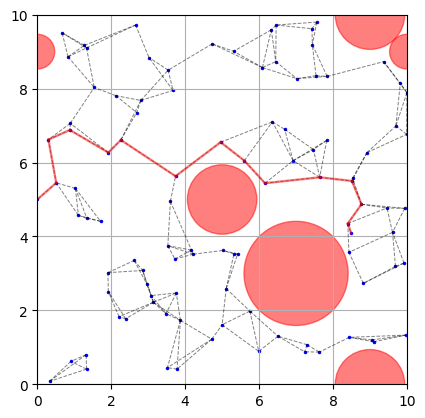

In [ ]:
visualise_plan(planner=prm,
               path_nodes=path_nodes,
               x_bounds=prm.configuration_space.bounds.x_bounds,
               y_bounds=prm.configuration_space.bounds.y_bounds,
               obstacle_list=prm.configuration_space.obstacle_list,
               interface_config={
                   "node_list": prm.roadmap.get_nodes,
                   "unique_edges": prm.roadmap.unique_edges
               })

start = Configuration2D(0,5)
goal = Configuration2D(9.49,7.99)

path_nodes = prm.query_roadmap(start, goal)



## Basic RRT Algorithm

Algorithms:

Let T be a tree (an acyclic graph).

1. initialise tree (for a given configuration space)
  - tree is implemented as an undirected graph $T= (V,E)$ that captures connectivity of the space.
  - nodes in $V$ are robot configurations sampled randomly from a uniform  distribution over $Q_{free}$, the free configuration space.
  - edges in $E$ represent connectedness in $Q_{free}$ (hence are undirected) and correspond to collision-free paths; an edge $(q_1, q_2)$ is such a path connecting configurations $q_1$ and $q_2$.
  - root node is the start configuration, $q_{start}$.
  - each edge is a local path generated by a local planner, $\Delta$.

2. extend tree (algorithm)
  - given random configuration, $q_{random}$ in $Q_{free}$ and a Tree $T$.
  - find nearest neighbour, $q_{near}$, of $q_{random}$ in $T$.
  - obtain $q_{new}$ by progressing $q_{near}$ by step_size towards $q_{random}$ along the straight line from $q_{near}$ to $q_{random}$.
  - if $q_{new}$ is collision-free, update $V$ and $E$ with $q_{new}$ and ($q_{near}$, $q_{new}$)
  - return $q_{new}$ or NULL


  $RRT$ exit condition: if new node is within rho (step size) of goal node and a collision-free straight line path connects new node to goal.
  
  $RRT Connect$ exit condition: when the two trees are connected.
  
  $RRT^*$: ...

### Basic RRT Pseudocode

In [ ]:
# Algorithm 1.0: build tree algorithm (pseudocode)

# Inputs:
# n: number of nodes to put in the tree
# d: incremental distance (step_size) to extend toward random sample
# q_start: start configuration
# q_goal: goal configuration
#
# Output:
# tree T = (V,E)

# V = {}
# E = {}
#
# T.init(q_start)
#
# while len(V) < n:
#
#   q_random = sample_free_configuration(Q, uniform, goal_bias=rand([0..1]))
#
#   q_new = T.extend(q_near, q_random, d)
#
#   T.add_node(q_new)
#
#   T.add_edge(q_near, q_new)
#
# return T

In [ ]:
# Algorithm 1.1: extend tree algorithm (pseudocode)

# Inputs:
# T: a rapidly exploring random tree (RRT)
# q_random: random configuration toward which tree, T, is grown
# step_size: extension step size
# rho: resolution
#
# Output:
# q_new | None: new configuration added to Tree or nil

# q_near = T.nearest_node(q_random)
#
# dist = distance(to=q_random, from=q_near)
# if dist < step_size:
#   step_size = dist
#
# q_new = q_near + (direction_vec(to=q_random, from=q_near) * step_size)  # progress/steer function
#
# if is_collision_free(q_new) and simple_local_planner(q_near, q_new, rho):
#   T.add_node(q_new)
#   T.add_edge(q_near, q_new)
#   return q_new
# return None

### Algorithm implementation

In [5]:
Probability = TypeVar('Probability', bound=float)
TreeEdge = dict[Literal["parent", "children"], Location | None | list[Location]]

class Tree(UndirectedWeightedGraph):
  def __init__(self, root: Location, distance_metric: Callable):
    """
    Initialize the tree with a root node and a distance metric.
      Args:
        root: The root node of the tree.
        distance_metric: The distance metric to use for calculating distances.
    """

    self.root = root
    self.distance_metric = distance_metric
    self._edges: dict[Location, TreeEdge] = {
        self.root: {
            "parent": None,
            "children": []
        }
    }

  @property
  def edges(self):
    """
    Class property getter representing edges in the graph
    """
    return self._edges

  @property
  def nodes(self):
    """
    Get nodes in the tree
    """
    return list(self._edges)

  def neighbours(self, node: Location) -> list[Location]:
    """
    Gets the neighbours of the given node.
      A neighbour has an edge from the given node to itself.

      Args:
        node (Node): The node for which neighbours are required.

      Returns:
        list[Node]: A list of all neighbouring Nodes.
    """
    return self._edges[node]

  def cost(self, start: Location, goal: Location) -> float:
    """
    Calculates the weight of the edge between fro and to nodes.

      Returns:
        float: The weight of the edge
    """
    return self.distance_metric(start, goal)

  def cost_to_root(self, node: Location):
    """Computes the cost to reach the root from node.

      Args:
        node: The node for which to compute the cost.

      Returns:
        The cost to reach node from the root.
      """
    assert self.has_node(node)
    cost = 0.0

    while self._edges[node]["parent"] is not None:  # reached root
      cost += self.cost(node, self._edges[node]["parent"])
      node = self._edges[node]["parent"]
    return cost

  def add_edge(self, parent: Location, child: Location) -> bool:
    if not self._edges[parent]:
      # parent not in tree
      return False

    # add child node to parent node
    self._edges[parent]["children"].append(child)  # TODO: make child list a set

    # handle existing children in case of rewiring
    children = self._edges.get(child, {}).get("children", [])

    self._edges[child] = {"parent": parent, "children": children}
    return True

  def nearest_node(self, node: Location) -> Location:
    """
    Gets the nearest node to the given node.
      A nearest node is the node in the Tree that is closest to the given node.

      Args:
        node (Node): The node for which the nearest node is required.

      Returns:
        Node: The nearest node to the given node.
    """
    return min(self.nodes, key=lambda n: self.distance_metric(node, n))

  def unique_edges(self) -> list[tuple[Location, Location]]:
    """
    Returns a list of unique edges in the tree.
    """
    edge_set = set()
    for node, edge in self._edges.items():
      for child in edge["children"]:
        edge_set.add((node, child))
    return list(edge_set)

  def has_node(self, node: Location) -> bool:
    return node in self

  def neighbourhood_within_rho(self, node: Location, rho: float = 1):
    # get all tree nodes within rho of node
    return [n for n in self if self.distance_metric(node, n) <= rho]

  def _remove_child(self, child: Location):
    parent = self._edges[child]["parent"]

    # remove child from parent
    if child in self._edges[parent]["children"]:
      self._edges[parent]["children"].remove(child)

  def rewire(self, node: Location, new_parent: Location):
    self._remove_child(node)  # delete child from parent, TODO: add rollback?
    if self.add_edge(parent=new_parent, child=node):
      return True

    return False

  def get_optimal_parent(self, child: Location,
                       neighbourhood: list[Location]) -> tuple[Location, dict]:
    """Get the optimal parent node for a given child node.

      The optimal parent node in the neighbourhood minimizes the cost function:

      ```
      f(n) = g(n) + h(n),
      ```

      where:

      * `g(n)` is the cost of the path from the root node to node `n`.
      * `h(n)` is the cost of the path from node `n` to the child node.

      Parameters:
        child: The child node.
        neighbourhood: The neighbourhood of the child node.

      Returns:
        The optimal parent node and the associated costs.
      """

    costs: dict[Location, list[float]] = {
        node: [
            # distance from neighbour node to root node
            self.cost_to_root(node),

            # distance from neigbour node to child node
            self.distance_metric(node, child)
        ]
        for node in neighbourhood
    }

    q_min = min(costs, key=lambda n_dist: n_dist(1) + n_dist(2))
    return q_min, costs


  def __len__(self) -> int:
    return len(self.nodes)

  def __contains__(self, key):
    return key in self.nodes

class RRTree:
  """
  Rapidly-exploring Random Tree (RRT) path planner.

    RRT is a sampling-based path planning algorithm useful for pathfinding in
    complex, high-dimensional configuration spaces.

    Args:
      start: The start configuration of the robot.
      goal: The goal configuration of the robot.
      num_samples: The maximum number of samples to add to the tree.
      goal_bias: The probability of selecting the goal as steering target.
      step_size: The maximum step size to take when steering.
      Q: The configuration space in which the robot is moving.
      local_planner: The local planner to use to plan local paths between
      configurations.
  """

  T: Tree

  def __init__(self,
               start: Location,
               goal: Location,
               num_samples: int,
               step_size: float,
               Q: ConfigurationSpace2D,
               local_planner: SimpleLocalPlanner2D,
               goal_bias: Probability = 0.3,
               build_on_init: bool = True):
    """
    Initialise RRTree
    """

    self.start = start
    self.goal = goal
    self.num_samples = num_samples
    self.step_size = step_size
    self.goal_bias = goal_bias
    self.configuration_space = Q
    self.local_planner = local_planner

    # Early exit: check if start and goal in Q_free
    self._path = False

    if not self.configuration_space.is_collision_free(
        self.start) or not self.configuration_space.is_collision_free(
            self.goal):
      self._path = None

    elif build_on_init:
      # Initialize the RRT tree | pathfound?
      self._build_tree(self.goal_bias)
      self._path = self._resolve_path()

  @property
  def path(self):
    return self._path

  def extend_tree(self,
                  near_config: Location,
                  target_config: Location,
                  step_size: float = 1) -> Location | None:

    # extend tree towards target_config for step size
    new_config = self.steer(near_config, target_config, step_size)

    if new_config:
      # update tree
      self.T.add_edge(parent=near_config, child=new_config)
      return new_config

    return None

  def steer(self,
            near_config: Location,
            target_config: Location,
            step_size: float = 1) -> Location | None:
    """
    Attempts to steer towards `target_config` from `near_config` in steps of `step_size`.

      Args:
          near_config: The configuration to steer from.
          target_config: The target configuration to steer towards.
          step_size (float, optional): The maximum step size to take. Defaults to 1.

      Returns:
          The new configuration if the steer is successful, otherwise None.
    """
    # Assumptions:
    # - all given configs are in Q_free
    # - the new_config is in Q_free

    # Get distance and adjust step_size as needed
    distance = self.configuration_space.distance_metric(
        near_config, target_config)

    if distance < step_size:
      step_size = distance

    # Get direction vector
    direction_vector = self.local_planner.get_increment_vector(
        near_config, target_config) / self.local_planner.resolution

    # Get new configuration
    new_config = (near_config.to_vector2D() +
     (direction_vector * step_size)).to_configuration2D()

    # Get local plan to new configuration
    if self.local_planner.plan(near_config, new_config):
      return new_config

    return None

  def _build_tree(self, goal_bias: Probability, resolution=0.01):
    # build tree
    self.T = Tree(root=self.start,
                   distance_metric=self.configuration_space.distance_metric)

    while len(self.T) < self.num_samples and self.goal not in self.T:
      # Get free config steering target
      if random.uniform(0, 1) <= goal_bias:
        sample_config: Location = self.goal
      else:
        sample_config: Location = self.sample_free_configuration(resolution)

      # Get nearest config to free config
      near_config = self.T.nearest_node(sample_config)

      # Steer towards random config
      self.extend_tree(near_config, sample_config, self.step_size)

  def _resolve_path(self) -> list[Location]:
    """
    Resolves the path from the start configuration to the goal configuration.

      Returns:
          The path from the start configuration to the goal configuration.
    """
    path = []

    # Early exit: check if goal in Tree
    if self.goal not in self.T:
      return None

    # Walk from goal to start
    current_node = self.goal

    while current_node is not None:
      path.append(current_node)
      current_node = self.T.edges.get(current_node, {
          "parent": None,
          "children": []
      })["parent"]

    if self.start not in path:
      print("Error: RRTree is broken!")
      return None

    # Reverse to get path from start
    return path[::-1]

  def sample_free_configuration(self, resolution=0.01) -> Location:
    """
    Sample a random configuration within the free configuration space.

      This method repeatedly samples random configurations until it finds one
      that is collision-free.

      Returns:
        A random collision-free configuration.
    """

    sample_config = sample_uniform_configuration2D(
        self.configuration_space.bounds, resolution)

    while not self.configuration_space.is_collision_free(sample_config):
      sample_config = sample_uniform_configuration2D(
          self.configuration_space.bounds, resolution)

    return sample_config



### RRT Tests

In [ ]:
# initialise RRT
# test simple 10x10 c-space path planning

start = Configuration2D(0,5)
goal = Configuration2D(8.49,4.09)

num_samples = 1000
step_size = .2

bounds = RectangularBounds2D(x_bounds=(0,10), y_bounds=(0,10))
obstacle_list = [
    DiskObstacle2D(centre=(5,5), radius=1),
    DiskObstacle2D(centre=(9,0), radius=1),
    DiskObstacle2D(centre=(9,10), radius=1),
    DiskObstacle2D(centre=(0,9), radius=0.5),
    DiskObstacle2D(centre=(10,9), radius=0.5),
    DiskObstacle2D(centre=(7,3), radius=1.5)
]
Q = ConfigurationSpace2D(bounds, obstacle_list)
local_planner = SimpleLocalPlanner2D(Q_space=Q)

rrt = RRTree(
    start=start,
    goal=goal,
    num_samples=num_samples,
    step_size=step_size,
    Q=Q,
    local_planner=local_planner,
    goal_bias=0.1
  )


path_nodes = rrt.path

### Visualise RRT

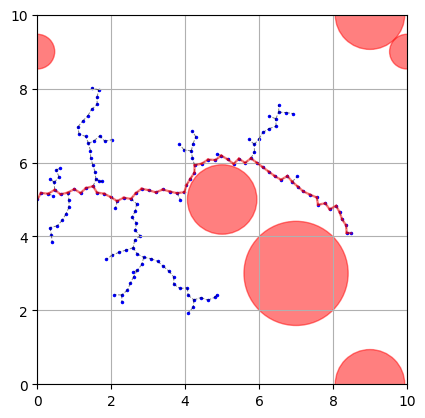

In [ ]:
visualise_plan(
    planner=rrt,
    path_nodes = rrt.path,
    x_bounds=rrt.configuration_space.bounds.x_bounds,
    y_bounds=rrt.configuration_space.bounds.y_bounds,
    obstacle_list=rrt.configuration_space.obstacle_list,
    interface_config={
        "node_list": rrt.T.nodes,
        "unique_edges": rrt.T.unique_edges
    })

## Basic RRT* Algorithm

Algorithms:

Let T be a tree (an acyclic graph).

1. initialise tree (for a given configuration space)
  - tree is implemented as an undirected graph $T= (V,E)$ that captures connectivity of the space.
  - nodes in $V$ are robot configurations sampled randomly from a uniform  distribution over $Q_{free}$, the free configuration space.
  - edges in $E$ represent connectedness in $Q_{free}$ (hence are undirected) and correspond to collision-free paths; an edge $(q_1, q_2)$ is such a path connecting configurations $q_1$ and $q_2$.
  - root node is the start configuration, $q_{start}$.
  - each edge is a local path generated by a local planner, $\Delta$.

2. extend tree (algorithm)
  - given random configuration, $q_{random}$ in $Q_{free}$ and a Tree $T$.
  - find nearest neighbour, $q_{near}$, of $q_{random}$ in $T$.
  - obtain $q_{new}$ by progressing $q_{near}$ by step_size towards $q_{random}$ along the straight line from $q_{near}$ to $q_{random}$.
  - if $q_{new}$ is collision-free,
    - connect $q_{new}$ to the node $q_{min}$ in the neighbourhood that minimises cost from start node $q_{start}$
    - rewire each node $q_{neighbour}$ in the neighbourhood through $q_{new}$ where this minimises the cost from $q_{min}$ to the $q_{neighbour}$.
    - return $q_{new}$
  - else: return NULL


   $RRT^*$ exit condition: if new node is within rho (step_size) of goal node and a collision-free straight line path connects new node to goal.

In [ ]:
# Algorithm 1.0: RRT-Star (pseudocode)

# Inputs:
# n: number of nodes to put in the tree
# d: incremental distance (step_size) to extend toward random sample
# q_start: start configuration
# q_goal: goal configuration

# Output:
# tree T = (V, E)

# V = {}  # Set of nodes
# E = {}  # Set of edges

# T.init(q_start)  # Initialize tree with start configuration

# while len(V) < n:
#     q_random = sample_free_configuration(Q, uniform, goal_bias=rand([0..1]))  # Sample random configuration
#     q_near = find_nearest_neighbor(q_random, T)  # Find nearest neighbor in existing tree
#     q_new = steer(q_near, q_random, d)  # Extend tree toward random sample and check collision
#     if q_new is not None:
#         neighbourhood = T.neighbourhood_within_rho(q_new, radius) ✔
#         q_min, neighbourhood_with_costs = get_optimal_parent(
#             q_new, candidates=neighbourhood)
#         E.add_edge(parent=q_min, child=q_new)  # Add edge to E
#         optimise_neighbourhood(q_min, q_new, neighbourhood_with_costs)
#
# return T



# Algorithm 1.1: optimise_neighbourhood (pseudocode)

# Inputs:
# q_min: node that minimises cost to start
# q_new: node through which neighbours are connected to q_min
# neighbourhood_with_costs: nodes within rho of q_new, each with costs to start

# Output:
# None

# q_new_cost_to_start = T.cost_to_root(q_new)
# for neighbour in neighbourhood:
#   if nwc[neighbour][1] > q_new_cost_to_start + nwc[neighbour][2]  # T.distance(start=q_new, goal=neighbour):
#     T.rewire(neighbour, q_new)



# Algorithm 1.2: T.rewire (pseudocode)

# Inputs:
# self: tree, T
# q_neighbour: neighbour node to rewire
# q_parent: new parent node

# Output:
# None

# T._remove_node(q_neighbour) - delete child from parent
# T.add_edge(parent=q_parent, child=q_neighbour)



# Algorithm 1.3: T.cost_to_root (pseudocode)

# Inputs:
# self: tree, T, containing node
# node: destination node

# Output:
# min. cost to go from given node to tree root along edges in the tree

# assert T.has_node(node) ✔️
# cost = 0.0
# while node.parent is not None:
#   cost += T.cost(node, node.parent)
#   node = node.parent
# return cost



# Algorithm 1.4: T.get_optimal_parent (pseudocode)

# Inputs:
# self: tree, T
# q_child: node for which an optimal parent is required
# candidates: candidate nodes in neighbourhood of q_child

# Output:
# q_min which minimises T.cost_to_start for q_new,
# neighbourhood_with_costs

# costs = {node: [T.cost_to_root(node), T.distance(
#     node, q_child)] for node in candidates}
# q_min = min( costs, key=lambda n: n(1)+n(2) )
# return q_min, costs

In [9]:
class RRTStar(RRTree):

  def __init__(self,
               start: Location,
               goal: Location,
               num_samples: int,
               step_size: float,
               Q: ConfigurationSpace2D,
               local_planner: SimpleLocalPlanner2D,
               goal_bias: Probability = 0.3,
               radius: float = 0.3):
    """Implements an RRT* search algorithm, specifically designed for optimal path planning in continuous configuration spaces.

    This algorithm is an extension of the Rapidly-exploring Random Tree (RRT) algorithm,
    and introduces a mechanism for optimizing the neighborhood of nodes in the tree
    to reduce the cost of the path to the goal.

    Args:
      start: The start configuration of the search.
      goal: The goal configuration of the search.
      num_samples: The number of samples to generate.
      step_size: The maximum step size to take when steering towards a new configuration.
      Q: The configuration space in which the search is performed.
      local_planner: The local planner used to generate feasible paths between configurations.
      goal_bias: The probability of steering towards the goal configuration instead of a random configuration.
      radius: The radius of the neighborhood within which to optimize the tree.
    """
    super().__init__(start,
                     goal,
                     num_samples,
                     step_size,
                     Q,
                     local_planner,
                     goal_bias,
                     build_on_init=False)
    # check early exit condition
    if self._path is not None:
      self._build_tree(self.goal_bias)
      self._path = super()._resolve_path()
      self.radius = radius

  def _build_tree(self,
                  goal_bias: Probability,
                  resolution: float = .01,
                  radius=0.3):
    self.T = Tree(root=self.start,
                  distance_metric=self.configuration_space.distance_metric)

    while len(self.T) < self.num_samples and self.goal not in self.T:
      # Get free config steering target
      if random.uniform(0, 1) <= goal_bias:
        sample_config: Location = self.goal
      else:
        sample_config: Location = self.sample_free_configuration(resolution)

      # Get nearest config to free sample config
      near_config = self.T.nearest_node(sample_config)

      # Steer towards random config
      new_config = super().steer(near_config, sample_config, self.step_size)

      if new_config:
        neighbourhood = self.T.neighbourhood_within_rho(new_config, radius)
        q_min, neighbourhood_with_costs = self.get_optimal_parent(
            new_config, neighbourhood)
        self.T.add_edge(parent=q_min, child=new_config)
        self._optimise_neighbourhood(q_min, new_config,
                                     neighbourhood_with_costs)

  def extend_tree(self,
                  near_config: Location,
                  target_config: Location,
                  step_size: float = 1):
    raise NotImplementedError("RRTStar does not support extend_tree")

  def optimise_neighbourhood(
      self,
      q_min: Location,  # node with minimum cost to root in neighbourhood
      q_new: Location,  # new node through which to optimise neighbourhood
      neighbourhood_with_costs: dict[Location, list[float]]
  ) -> None:
    """Optimise neighbourhood nodes (rewire edges) for better optimality.

    Args:
      q_min: node with minimum cost to root in neighbourhood
      q_new: new node through which to optimise neighbourhood
      neighbourhood_with_costs: dictionary of neighbourhood nodes and their costs
    """
    q_new_cost_to_root = self.T.cost_to_root(q_new)
    for neighbour in neighbourhood_with_costs:
      if neighbourhood_with_costs[neighbour][
          1] > q_new_cost_to_root + neighbourhood_with_costs[neighbour][2]:
        self.T.rewire(neighbour, q_new)

  def super():
    raise NotImplementedError("RRTStar does not support super")